# Project: Geography and occupancy of public schools in Vilnius municipality

## Project and goals
This is a toy project intended to demonstrate the capabilities of working on publicly available data, extracting information both by direct inspection/analysis and by employing ML tools. <br> The *problem* of the project is the following: analyze the trends of school occupation in Vilnius municipality with a particular focus on the spatial/geographical distribution.

## Data
The data used in the project are openly accessible in the github.com account of Vilnius city (https://github.com/vilnius)
Particularly we used two databases:
- mokyklu_teritorijos_pagal_adresus.csv (https://github.com/vilnius/mokyklos)
- registered_people_n_streets.csv (https://github.com/vilnius/gyventojai)

We additionally used "external" data from the city council's website „Pagrindiniai duomenys apie Vilniaus miesto savivaldybės švietimo įstaigas“ 
https://vilnius.lt/lt/savivaldybe/svietimas-kultura-ir-sportas/svietimas/pagrindiniai-duomenys-apie-vilniaus-miesto-savivaldybes-svietimo-istaigas/
where the data has already been cleaned (e.g., filltering out the music schools) and better organized (e.g., number of students per school calculated). The data were separately placed into the table mokyklu_info.csv.

The maps were both cropped from www.maps.lt and exported picking the bounding box from
http://zemelapiai.vplanas.lt/arcgis/rest/services/Open_Data/Vilniaus_miesto_ribos/MapServer

In [2]:
%matplotlib inline
import os.path
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import SpectralClustering

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "D:/cygwin64/home/harad/DataSci/Mokyklos/"

Functions for saving/plotting figures and parsing data

In [72]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """
    A simple wrapper for saving figures as pnd files
    """
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, transparent=False, format=fig_extension, dpi=resolution)

    
    
def plot_with_map(map_image=True, frame_image=True):
    """
    Plots actual topographical map and/or frames of the boroughs as a backdrop for coordinate figures
    
    Parameters: 
        map_image: bool, optional
        plots the topographical map image
    
        fram_image: bool, optional
        plots the frame immge of the borough boundaries
    """
    vilnius_img=mpimg.imread(PROJECT_ROOT_DIR + "Vilnius.png")
    vilnius_frame=mpimg.imread(PROJECT_ROOT_DIR + "Vilnius_frame.png")

    map_extent = [566389, 595582, 6048575.0, 6078091.0]
    frame_extent = [565869.0, 596262.0, 6048075.0, 6078091.0]
    
    if map_image:
        plt.imshow(vilnius_img, extent=map_extent, alpha=0.8)
    
    if frame_image:
        plt.imshow(vilnius_frame, extent=frame_extent, alpha=0.2)
        
    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)
        


def read_school_info(filename):
    """
    Parses imput .csv flie with school data
    
    Parameters:
        filename: string
        The name of the input file
        
    Returns:
        school_info: pd.DataFrame
        A data frame containing school Id, address and the number of students            
    """
    if not os.path.isfile(PROJECT_ROOT_DIR+filename):
        raise IOError('The path to user data is invalid')
    
    # read file
    aux =  pd.read_csv(PROJECT_ROOT_DIR + filename)
    
    # select only the necessary columns
    # ['IstaigosKodas', 'ADRESAS', 'MokiniuSkaicius']
    school_info = aux.iloc[:,[1,3,4]]
    school_info.columns = ['ID', 'ADDRESS', 'STUDENTS']
    
    return school_info

    
    
def read_address_info(filename):
    """
    Parses imput .csv flie with the address and coordinate data
    
    Parameters:
        filename: string
        The name of the input file
        
    Returns:
        address_to_coord: pd.DataFrame
        A data frame containing addresses, the corresponding longitudes and latitudes in LKS system,
        and the names of the corresponding boroughs
    """
    if not os.path.isfile(PROJECT_ROOT_DIR+filename):
        raise IOError('The path to user data is invalid')
    
    # read file
    aux =  pd.read_csv(PROJECT_ROOT_DIR + filename,
                      sep = ';', low_memory = False)
    
    # select only the necessary columns
    # ['ADRESAS', 'X_KOORD', 'Y_KOORD', 'SENIUNIJA']
    address_to_coord = aux.iloc[:,[14,9,10,15]]
    address_to_coord.columns = ['ADDRESS', 'X_COORD', 'Y_COORD', 'BOROUGH']
    
    return address_to_coord



def read_resident_info(filename):
    """
    Parses imput .csv flie with the residents' data
    
    Parameters:
        filename: string
        The name of the input file
        
    Returns:
        resident_info: pd.DataFrame
        A data frame containing year of birth and resident's borough name
    """
    if not os.path.isfile(PROJECT_ROOT_DIR+filename):
        raise IOError('The path to user data is invalid')
    
    # read file
    aux =  pd.read_csv(PROJECT_ROOT_DIR + filename)
    
    # select only the necessary columns
    # ['GIMIMO_METAI', 'SENIUNIJA']
    resident_info = aux.loc[:,["GIMIMO_METAI","SENIUNIJA"]]
    resident_info.columns = ["BIRTH_YEAR", "BOROUGH"]
    
    return resident_info

## Parsing of data and some initial overview

In [73]:
school_info = read_school_info("mokyklu_info.csv")
address_to_coord = read_address_info("mokyklu_teritorijos_pagal_adresus.csv")
resident_info = read_resident_info("registered_people_n_streets.csv")

print("Number of schools: ", len(school_info))
print("Number of students: ", school_info.STUDENTS.sum())

Number of schools:  115
Number of students:  61993


Let us combine the two data sets to have all the information about the schools and their geography:

In [74]:
school_and_coord = pd.merge(school_info, address_to_coord, on='ADDRESS', how='left')
school_and_coord.head()

,ID,ADDRESS,STUDENTS,X_COORD,Y_COORD,BOROUGH
0,191665861,Genių g. 25,161,6062220.0,591840.0,Naujoji Vilnia
1,190032365,Medeinos g. 5,173,6066482.0,578753.0,Pašilaičiai
2,190016165,Taikos g. 97,210,6065682.0,578130.0,Justiniškės
3,191665480,Fabijoniškių g. 23,368,6065910.0,580246.0,Fabijoniškės
4,190009167,Taikos g. 189,438,6064717.0,578101.0,Justiniškės


In [67]:
print("Distribution of schools by boroughs:")
print(school_and_coord["BOROUGH"].value_counts())

Distribution of schools by boroughs:
Naujamiestis       11
Naujoji  Vilnia     9
Žirmūnai            9
Senamiestis         8
Šeškinė             8
Karoliniškės        8
Antakalnis          6
Lazdynai            6
Justiniškės         6
Fabijoniškės        5
Viršuliškės         5
Pašilaičiai         5
Naujininkai         5
Šnipiškės           4
Žvėrynas            4
Verkiai             4
Grigiškės           4
Vilkpėdė            3
Pilaitė             2
Rasos               2
Paneriai            1
Name: BOROUGH, dtype: int64


Let us look at how the school are distributed within the city. We use color code to mark the number of students in the school.

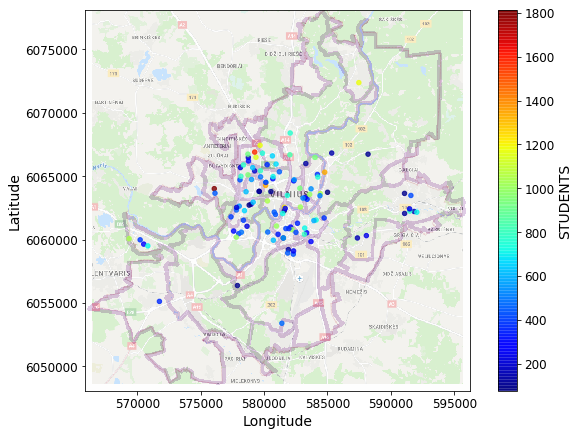

In [70]:
# plot schools on the map, color-coding the number of students
ax = school_and_coord.plot(kind="scatter", x="Y_COORD", y="X_COORD",
                         figsize=(10,7), alpha=0.8, sharex=False,
                         c="STUDENTS", cmap=plt.get_cmap("jet"),
                         colorbar=True)
plot_with_map()
plt.show()

Looks like the absolute majority of schools are clustered at or around the city center. This alone tells us little about how well the geography of schools is adapted to the local needs, because we need to take into account the distribution of the population as well, especially the distribution of school-aged children.

## Borough data
Let us gather/aggregate some information about boroughs, as logocal geographic units of the municipality. Primarily we are interested in the distribution of students and children in the boroughs.

In [111]:
# create a data set of students per borough
aux1 = school_and_coord[["BOROUGH","STUDENTS"]].groupby(["BOROUGH"]).sum()
students_by_borough = aux1.reset_index()

# create a data set of children per borough
aux2 = resident_info[["BIRTH_YEAR", "BOROUGH"]].query('BIRTH_YEAR > 2001 & BIRTH_YEAR < 2013')
# probably there's a more pandasic way; here I apply "whatever works, works"
children_by_borough = aux2["BOROUGH"].value_counts().reset_index()
children_by_borough.rename({"index": "BOROUGH", "BOROUGH": "CHILDREN"}, axis='columns', inplace=True)

# join the data frames
borough_info = pd.merge(students_by_borough, children_by_borough, on="BOROUGH", how='left')
borough_info

,BOROUGH,STUDENTS,CHILDREN
0,Antakalnis,3228,4830
1,Fabijoniškės,3618,4412
2,Grigiškės,2422,1213
3,Justiniškės,3055,2908
4,Karoliniškės,3207,2306
5,Lazdynai,2820,3417
6,Naujamiestis,5365,3163
7,Naujininkai,1741,3120
8,Naujoji Vilnia,2917,4160
9,Paneriai,366,1059


In [120]:
print("Total number of students: ", borough_info.STUDENTS.sum())
print("Total number of children: ", borough_info.CHILDREN.sum())

Total number of students:  62732
Total number of children:  63626


As we can see, there is some mis-match of the number of students and school-aged children in the municipality. The likely reasons for the mismatch are different sources, which might provide data from different years, the data limits in the query and some objective ones (e.g., some children might not attend school, be home-taught, and the like). Ultimately, however, the numbers coincide pretty well and we can assume that all the children are distributed by boroughs as students.

In order to plot borough info on the map we introduce the *weighted borough coordinates*. We use the coordinates of the schools within a borough and average these coordinates using numbers of students in those schools as weights. Namely, the weighted borough coordinates (or simply borough coordinates) are: $X_{bor} = \sum_i{X_i * N_i}/\sum_i{N_i}$ and $Y_{bor} = \sum_i{Y_i * N_i}/\sum_i{N_i}$, where the summation runs over schools with coordinates $X_i, Y_i$ and number of students $N_i$.

In [112]:
school_and_coord["X_WEIGHT"] = school_and_coord.X_COORD * school_and_coord.STUDENTS
school_and_coord["Y_WEIGHT"] = school_and_coord.Y_COORD * school_and_coord.STUDENTS

x_y_weight = school_and_coord[["BOROUGH", "X_WEIGHT", "Y_WEIGHT"]].groupby(["BOROUGH"]).sum()
x_y_weight.reset_index(inplace=True)

borough_info = pd.merge(borough_info, x_y_weight, on="BOROUGH", how='left')
borough_info["X_BOR"] = borough_info.X_WEIGHT/borough_info.STUDENTS
borough_info["Y_BOR"] = borough_info.Y_WEIGHT/borough_info.STUDENTS

Having the means to mark the boroughs on the map, let us see how the students and children are distributed over the boroughs. The size of the disc corresponds to the school-aged children population of the borough, the colour intesnity marks the number of students within the borough.

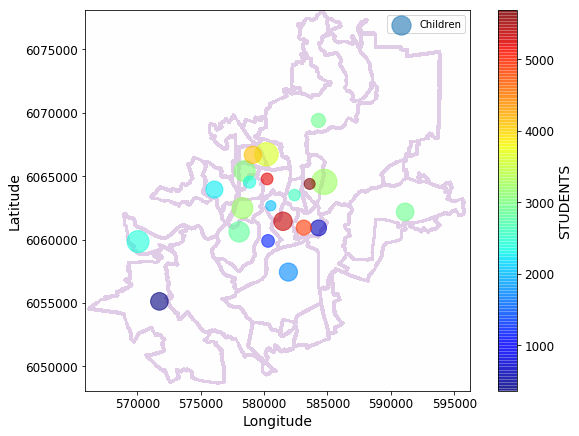

In [116]:
ax = borough_info.plot(kind="scatter", x="Y_BOR", y="X_BOR",
                       figsize=(10,7), alpha=0.6, sharex=False,
                       s=children_by_borough["CHILDREN"]/10, label="Children",
                       c="STUDENTS", cmap=plt.get_cmap("jet"), colorbar=True)
plot_with_map(map_image=False)
plt.show()

Evidently, in some boroughs with less children (smaller discs) there are more students (more intense colour) than in some boroughs with more children (larger discs). <br>
Let us explore this discrepancy further. Let us plot the number of students in the boroughs against the number of children. The diagonal of this plot corresponds to the boroughs in which both are equal (hence, the numbers are balanced).

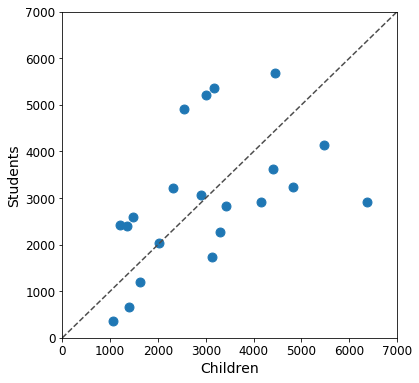

In [122]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(borough_info.CHILDREN, borough_info.STUDENTS, s=80)
ax.set(xlim=(0, 7000), ylim=(0, 7000))
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel("Children", fontsize=14)
plt.ylabel("Students", fontsize=14)
plt.show()

The two parameters clearly correlate positively: the more children in a borough, the more students. At the same time, however, some of the boroughs are well above the diagonal (more students than children), some are below (hence, "donating" students to other boroughs).

We can analyze this distribution further by clustering the data. A very representative grouping is achieved by determining four clusters. We use `sklearn` 's `SpectralClustering` for this task (avoiding trivial linear decision boundaries).

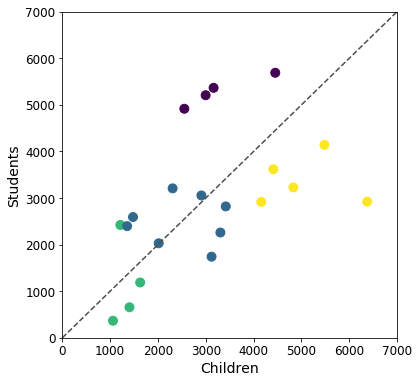

In [126]:
model = SpectralClustering(n_clusters=4, affinity='nearest_neighbors',
                           assign_labels='kmeans')
X = borough_info[["CHILDREN","STUDENTS"]].copy()
X["LABELS"] = model.fit_predict(X)

# let us see the result
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X.CHILDREN, X.STUDENTS, c=X["LABELS"], s=80, cmap='viridis')
ax.set(xlim=(0, 7000), ylim=(0, 7000))
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.xlabel("Children", fontsize=14)
plt.ylabel("Students", fontsize=14)
plt.show()

The algorithm identifies four clusters that actually have a clear meaning:
- The group of mid-sized boroughs above the diagonal, hence accepting a lot of students
- The group of large (in children population) boroughs that donate students to other boroughs (below the diagonal and to the right)
- The group of small boroughs largely donating students to other boroughs (below diagonal and to the left)
- The group of mid-sized mixed (donating and accepting) boroughs (the circle on the diagonal)

Let us look at the geographical distribution of these clusters:

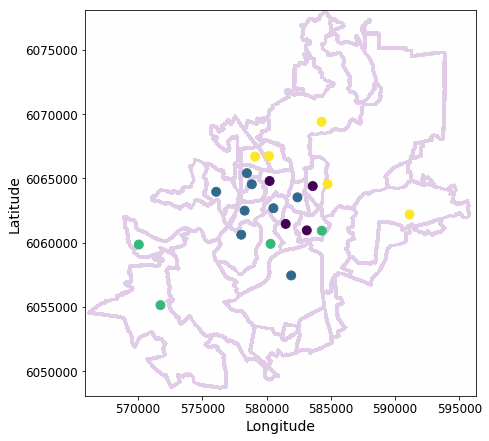

In [130]:
borough_info["LABELS"] = X.LABELS

f, ax = plt.subplots(figsize=(7, 10))
ax = plt.scatter(borough_info.Y_BOR, borough_info.X_BOR,
                 s=80, c=borough_info.LABELS, cmap="viridis")
plot_with_map(map_image=False)
plt.show()

The determined clusters appear to be also surprisingly clusterred geographically. Namely, the large donor boroughs are exceptionally the North - North-East boundary boroughs, the least populous donor boroughs are mostly the ones at the South - South-West. The mid-sized student-accepting boroughs are nested in the city center. The mid-sized, mixed boroughs are mostly central and Western. <br>
***
The results demonstrate that there is a clear systematic and geographically distributed discrepancy among publick schools in terms of the occupancy with respect to the population of the boroughs. Such a discrepancy via daily student flux from student-donor boroughs to the student-acceptor boroughs and back could potentially have a disrupting and detrimental effect on the functioning of the city.